# Hyper-Pyramid

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# seed the random number generator
rstate = np.random.default_rng(121)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [3]:
import dynesty

One of the key assumptions of (Static) Nested Sampling is that we "shrink" according to

$$ X_{i} = t_i X_{i-1} ~ , \quad t_i \sim \textrm{Beta}(K, 1) $$

at each iteration. We can empirically test this by using functions whose volumes can be analytically computed directly from the position of a sample. One example of this is the "hyper-pyramid" function whose log-likelihood is

$$ \ln \mathcal{L} = - \left( \sup_i \left| \frac{x_i - \frac{1}{2}}{\sigma_i} \right| \right)^{1/s} $$

where $s$ controls the "slope" and $\sigma_i$ controls the "scale" in each dimension. Here we'll take $s=100$ and $\sigma_i = \sigma = 1$ following [Buchner (2014)](https://arxiv.org/abs/1407.5459).

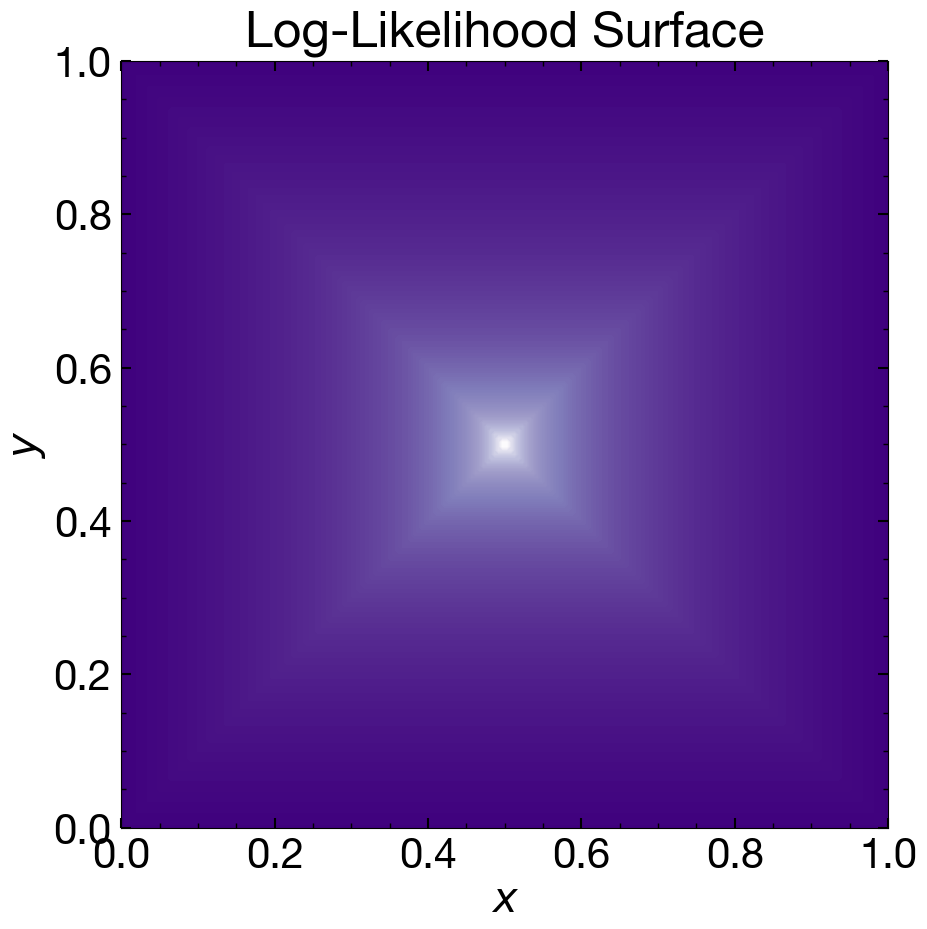

In [4]:
# define the eggbox log-likelihood
s, sigma = 100., 1.
def loglike(x):
    return -max(abs((x - 0.5) / sigma))**(1. / s)

# define the prior transform
def prior_transform(x):
    return x

# plot the log-likelihood surface
plt.figure(figsize=(10., 10.))
axes = plt.axes(aspect=1)
xx, yy = np.meshgrid(np.linspace(0., 1., 200),
                     np.linspace(0., 1., 200))
L = np.array([loglike(np.array([x, y]))
              for x, y in zip(xx.flatten(), yy.flatten())])
L = L.reshape(xx.shape)
axes.contourf(xx, yy, L, 200, cmap=plt.cm.Purples_r)
plt.title('Log-Likelihood Surface', y=1.01)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.tight_layout()

We will now sample from this distribution using `'multi'`. We will change the defaults so that our bounding updates begin immediately.

In [5]:
ndim = 2
nlive = 500
sampler = dynesty.NestedSampler(loglike, prior_transform, ndim=ndim, bootstrap=50,
                                first_update={'min_ncall': 0, 'min_eff': 100.},
                                bound='multi', sample='unif', nlive=nlive, 
                                rstate=rstate)
sampler.run_nested(dlogz=0.01, maxiter=1500, add_live=False)
res = sampler.results

1501it [00:16, 92.09it/s, bound: 7 | nc: 1 | ncall: 3646 | eff(%): 41.168 | loglstar:   -inf < -0.979 <    inf | logz: -1.041 +/-  0.010 | dlogz:  0.053 >  0.010]


Let's now compare the set of samples with the expected theoretical shrinkage. The contours for the bounding volume
are given directly $\mathcal{L}$ since $x_i = [r_0 − 1/2, r_0 + 1/2]$, where 

$$ r_0 = (- \ln \mathcal{L})^s = \sup_i \left| \frac{x_i - \frac{1}{2}}{\sigma_i} \right| $$

The corresponding volume is a hyper-rectangle (N-cube) with

$$ V = (2 \cdot r_0)^d \times \prod_i \sigma_i = (2 \cdot r_0)^d \quad .$$

The PDF of the shrinkage $t$ is

$$ P(t \,|\, K) = (1-t)^{K-1} $$

which has a CDF of 

$$ P(t < T \,|\, K) = t^K \quad . $$

Following Buchner (2014), we can define the quantity

$$ s = 1 - t^{1/d} $$

that represents the side being "sliced" away. This now has a cumulative distribution of

$$ P(s < S) = 1 - (1 - S)^{dN} $$

which is a bit easier to visualize.

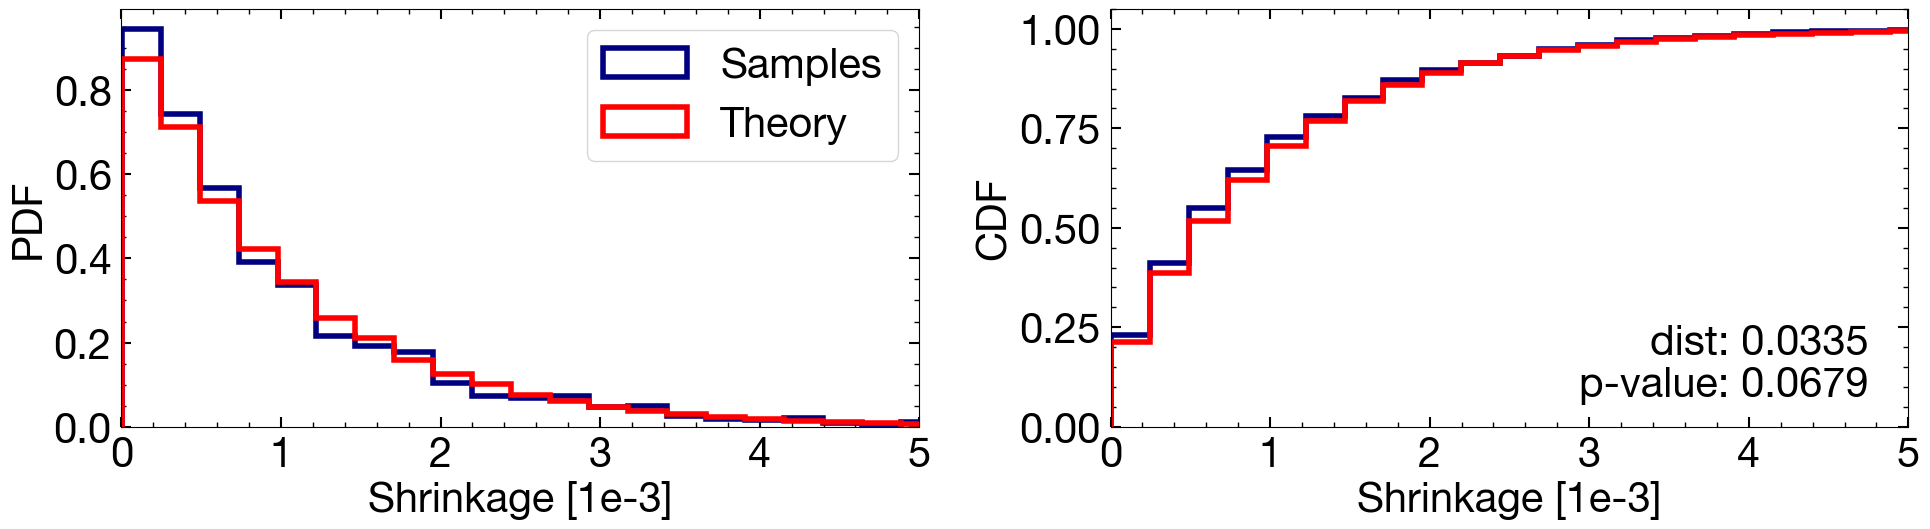

In [6]:
from scipy.stats import kstest

vol = (2 * (-res['logl'])**s)**ndim  # real volumes
t = vol[1:] / vol[:-1]  # shrinkage
S = 1 - t**(1. / ndim)  # slice

# define our PDF/CDF
def pdf(s):
    return ndim * nlive * (1. - s)**(ndim * nlive - 1.)
def cdf(s):
    return 1. - (1. - s)**(ndim * nlive)

# check whether the two distributions are consistent
k_dist, k_pval = kstest(S, cdf)

# plot results
xgrid = np.linspace(0., 0.1, 10000)

# PDF
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
ax = axes[0]
pdfgrid = pdf(xgrid)
n, b, p = ax.hist(S * 1e3, bins=50, histtype='step', 
                  color='navy', density=True, lw=4, label='Samples')
ax.hist(xgrid * 1e3, bins=b, color='red', density=True,
        weights=pdfgrid, lw=4, histtype='step', label='Theory')
ax.set_xlabel('Shrinkage [1e-3]')
ax.set_xlim([0., 5])
ax.set_ylabel('PDF')
ax.legend()

# CDF
ax = axes[1]
cdfgrid = cdf(xgrid)
n, b, p = ax.hist(S * 1e3, bins=50, histtype='step',
                  cumulative=True, color='navy', 
                  density=True, lw=4, label='Theory')
ax.hist(xgrid * 1e3, bins=b, color='red', density=True,
        weights=pdfgrid, lw=4, cumulative=True,
        histtype='step', label='Theory')
ax.set_xlabel('Shrinkage [1e-3]')
ax.set_xlim([0., 5])
ax.set_ylabel('CDF')
ax.text(0.95, 0.2, 'dist: {:6.3}'.format(k_dist), 
        horizontalalignment='right', verticalalignment='center',
        transform=ax.transAxes)
ax.text(0.95, 0.1, 'p-value: {:6.3}'.format(k_pval), 
        horizontalalignment='right', verticalalignment='center',
        transform=ax.transAxes)

plt.tight_layout()

Now let's turn bootstrapping off.

In [7]:
ndim = 2
sampler = dynesty.NestedSampler(loglike, prior_transform, ndim=ndim,
                                bootstrap=0,
                                enlarge=1,
                                bound='multi', sample='unif', nlive=nlive,
                                first_update={'min_ncall': 0, 'min_eff': 100.},
                               rstate=rstate)
sampler.run_nested(dlogz=0.01, maxiter=1500, add_live=False)
res = sampler.results

1501it [00:00, 1504.25it/s, bound: 6 | nc: 1 | ncall: 3219 | eff(%): 46.629 | loglstar:   -inf < -0.978 <    inf | logz: -1.041 +/-  0.010 | dlogz:  0.053 >  0.010]


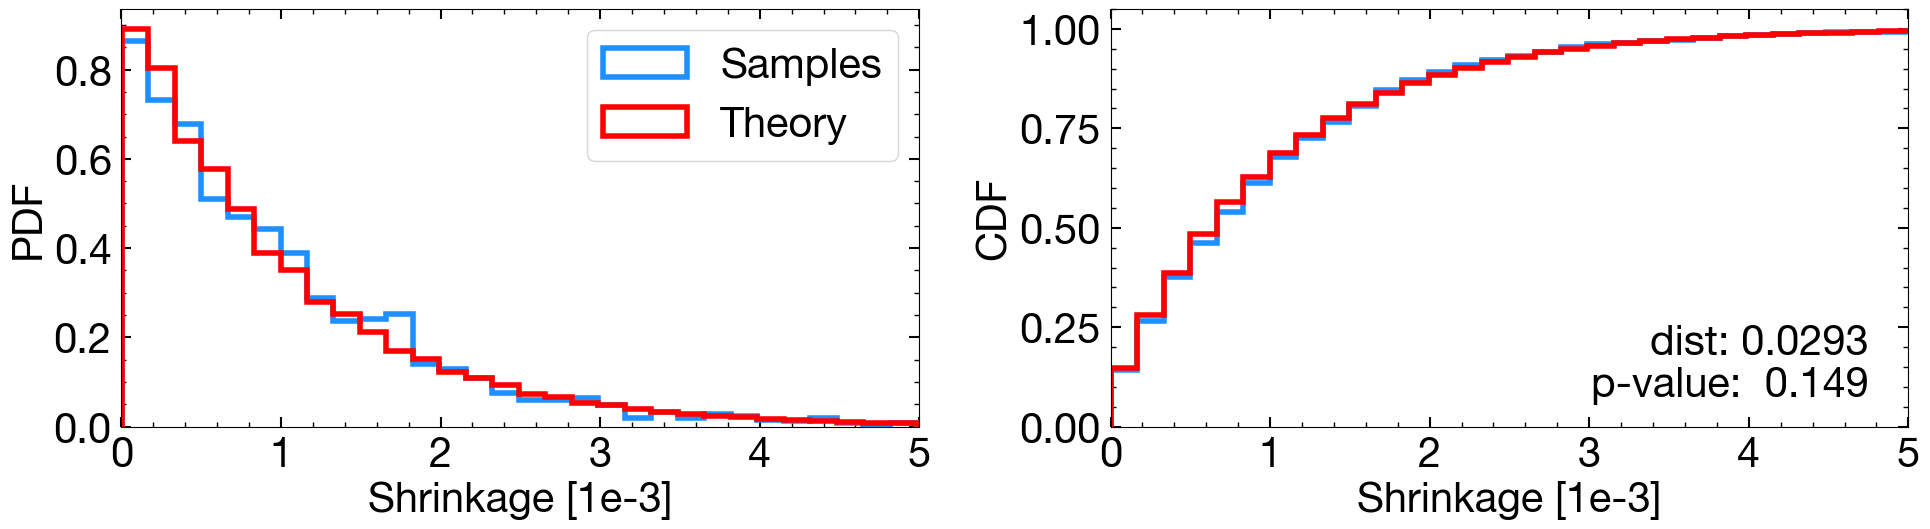

In [8]:
vol = (2 * (-res['logl'])**s)**ndim  # real volumes
t = vol[1:] / vol[:-1]  # shrinkage
S = 1 - t**(1. / ndim)  # slice

# check whether the two distributions are consistent
k_dist, k_pval = kstest(S, cdf)

# PDF
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
ax = axes[0]
pdfgrid = pdf(xgrid)
n, b, p = ax.hist(S * 1e3, bins=50, histtype='step', 
                  color='dodgerblue', density=True, lw=4, label='Samples')
ax.hist(xgrid * 1e3, bins=b, color='red', density=True,
        weights=pdfgrid, lw=4, histtype='step', label='Theory')
ax.set_xlabel('Shrinkage [1e-3]')
ax.set_xlim([0., 5])
ax.set_ylabel('PDF')
ax.legend()

# CDF
ax = axes[1]
cdfgrid = cdf(xgrid)
n, b, p = ax.hist(S * 1e3, bins=50, histtype='step',
                  cumulative=True, color='dodgerblue', 
                  density=True, lw=4, label='Theory')
ax.hist(xgrid * 1e3, bins=b, color='red', density=True,
        weights=pdfgrid, lw=4, cumulative=True,
        histtype='step', label='Theory')
ax.set_xlabel('Shrinkage [1e-3]')
ax.set_xlim([0., 5])
ax.set_ylabel('CDF')
ax.text(0.95, 0.2, 'dist: {:6.3}'.format(k_dist), 
        horizontalalignment='right', verticalalignment='center',
        transform=ax.transAxes)
ax.text(0.95, 0.1, 'p-value: {:6.3}'.format(k_pval), 
        horizontalalignment='right', verticalalignment='center',
        transform=ax.transAxes)

plt.tight_layout()

We see that without incorporating the bootstrap expansion factors the ellipsoids have a tendency to over-constrain the remaining prior volume and shrink too quickly. What happens if we increase the number of dimensions?

In [9]:
ndim = 7
sampler = dynesty.NestedSampler(loglike, prior_transform, ndim=ndim, bootstrap=50,
                                bound='multi', sample='unif', nlive=nlive, 
                                first_update={'min_ncall': 0, 'min_eff': 100.},
                               rstate=rstate)
sampler.run_nested(dlogz=0.01, maxiter=1500, add_live=False)
res = sampler.results

1501it [00:13, 111.10it/s, bound: 16 | nc: 15 | ncall: 8353 | eff(%): 17.970 | loglstar:   -inf < -0.989 <    inf | logz: -1.044 +/-  0.010 | dlogz:  0.052 >  0.010]


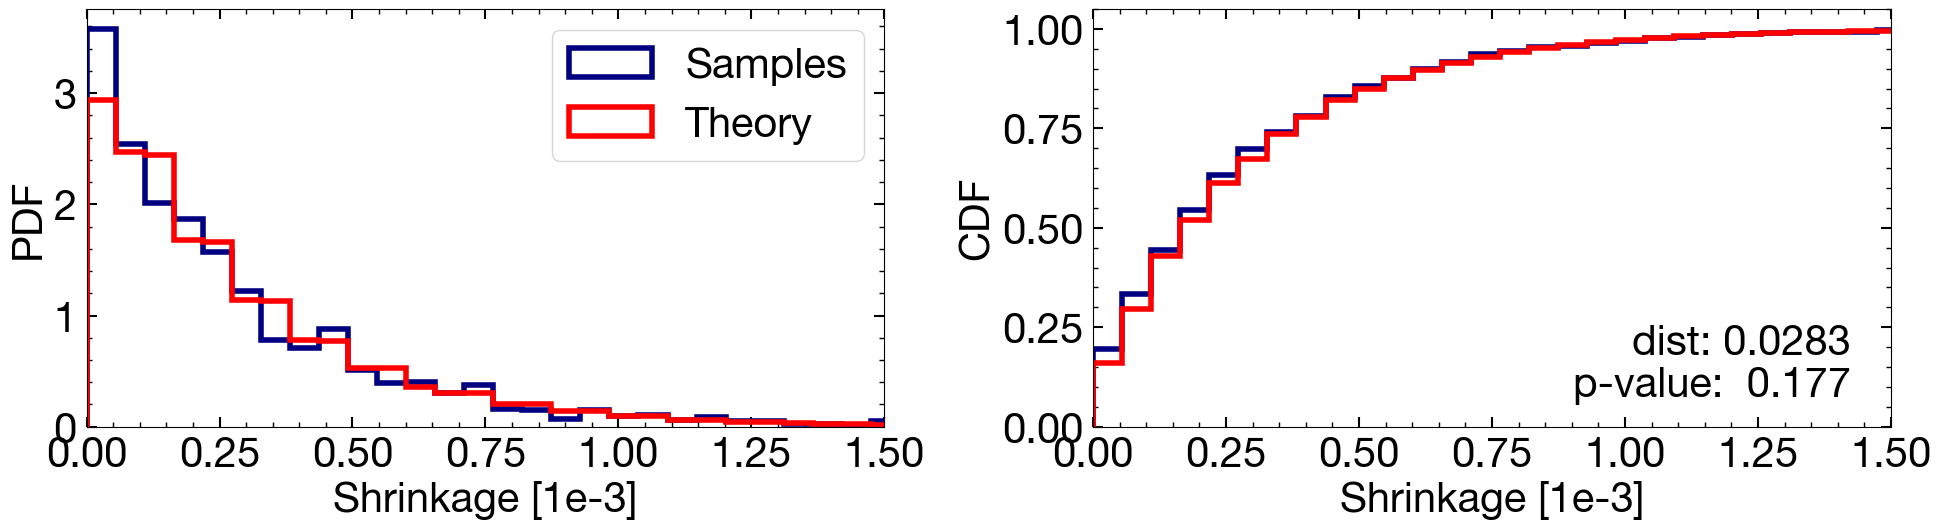

In [10]:
vol = (2 * (-res['logl'])**s)**ndim  # real volumes
t = vol[1:] / vol[:-1]  # shrinkage
S = 1 - t**(1. / ndim)  # slice

# check whether the two distributions are consistent
k_dist, k_pval = kstest(S, cdf)

# PDF
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
ax = axes[0]
pdfgrid = pdf(xgrid)
n, b, p = ax.hist(S * 1e3, bins=50, histtype='step', 
                  color='navy', density=True, lw=4, label='Samples')
ax.hist(xgrid * 1e3, bins=b, color='red', density=True,
        weights=pdfgrid, lw=4, histtype='step', label='Theory')
ax.set_xlabel('Shrinkage [1e-3]')
ax.set_xlim([0., 1.5])
ax.set_ylabel('PDF')
ax.legend()

# CDF
ax = axes[1]
cdfgrid = cdf(xgrid)
n, b, p = ax.hist(S * 1e3, bins=50, histtype='step',
                  cumulative=True, color='navy', 
                  density=True, lw=4, label='Theory')
ax.hist(xgrid * 1e3, bins=b, color='red', density=True,
        weights=pdfgrid, lw=4, cumulative=True,
        histtype='step', label='Theory')
ax.set_xlabel('Shrinkage [1e-3]')
ax.set_xlim([0., 1.5])
ax.set_ylabel('CDF')
ax.text(0.95, 0.2, 'dist: {:6.3}'.format(k_dist), 
        horizontalalignment='right', verticalalignment='center',
        transform=ax.transAxes)
ax.text(0.95, 0.1, 'p-value: {:6.3}'.format(k_pval), 
        horizontalalignment='right', verticalalignment='center',
        transform=ax.transAxes)

plt.tight_layout()

In [11]:
ndim = 7
sampler = dynesty.NestedSampler(loglike, prior_transform, ndim=ndim,
                                bound='multi', sample='unif', nlive=nlive, 
                                first_update={'min_ncall': 0, 'min_eff': 100.},
                               rstate=rstate)
sampler.run_nested(dlogz=0.01, maxiter=1500, add_live=False)
res = sampler.results

1501it [00:02, 550.24it/s, bound: 15 | nc: 3 | ncall: 7782 | eff(%): 19.288 | loglstar:   -inf < -0.989 <    inf | logz: -1.044 +/-  0.010 | dlogz:  0.052 >  0.010] 


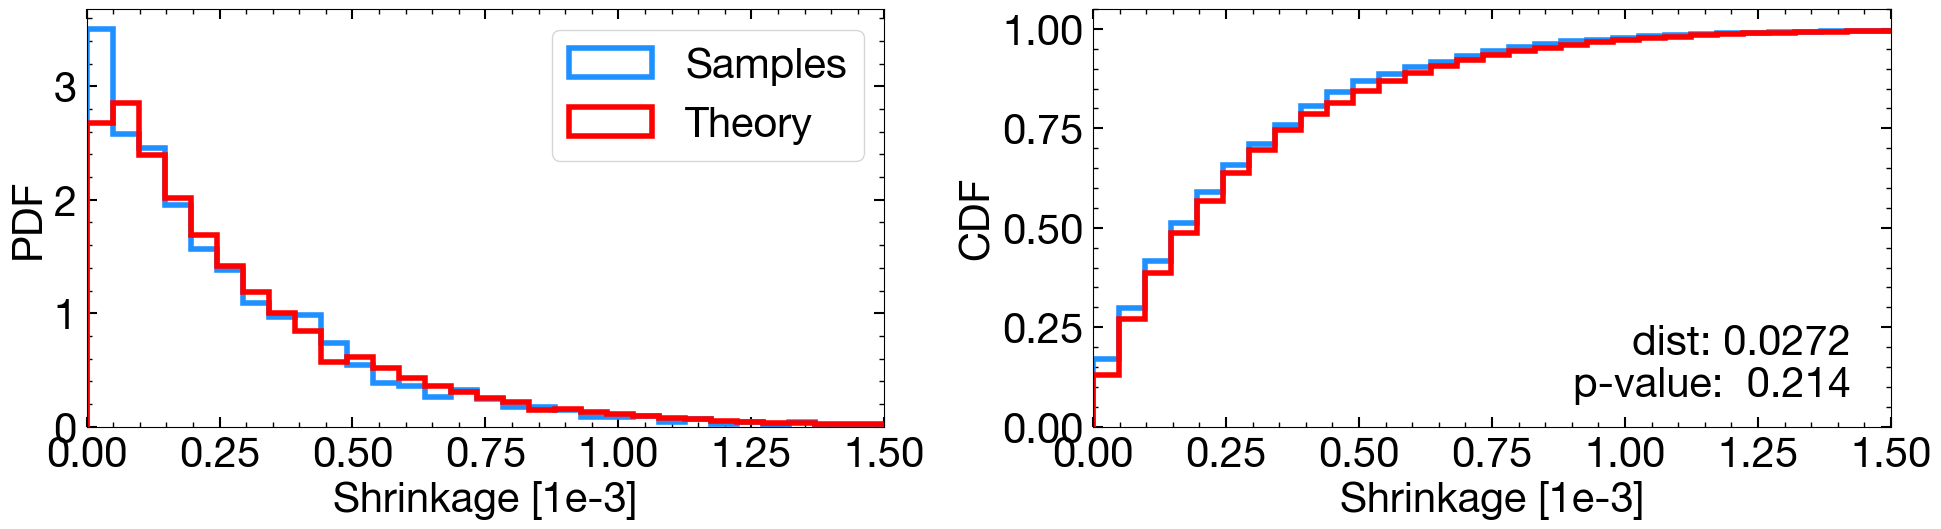

In [12]:
vol = (2 * (-res['logl'])**s)**ndim  # real volumes
t = vol[1:] / vol[:-1]  # shrinkage
S = 1 - t**(1. / ndim)  # slice

# check whether the two distributions are consistent
k_dist, k_pval = kstest(S, cdf)

# PDF
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
ax = axes[0]
pdfgrid = pdf(xgrid)
n, b, p = ax.hist(S * 1e3, bins=50, histtype='step', 
                  color='dodgerblue', density=True, lw=4, label='Samples')
ax.hist(xgrid * 1e3, bins=b, color='red', density=True,
        weights=pdfgrid, lw=4, histtype='step', label='Theory')
ax.set_xlabel('Shrinkage [1e-3]')
ax.set_xlim([0., 1.5])
ax.set_ylabel('PDF')
ax.legend()

# CDF
ax = axes[1]
cdfgrid = cdf(xgrid)
n, b, p = ax.hist(S * 1e3, bins=50, histtype='step',
                  cumulative=True, color='dodgerblue', 
                  density=True, lw=4, label='Theory')
ax.hist(xgrid * 1e3, bins=b, color='red', density=True,
        weights=pdfgrid, lw=4, cumulative=True,
        histtype='step', label='Theory')
ax.set_xlabel('Shrinkage [1e-3]')
ax.set_xlim([0., 1.5])
ax.set_ylabel('CDF')
ax.text(0.95, 0.2, 'dist: {:6.3}'.format(k_dist), 
        horizontalalignment='right', verticalalignment='center',
        transform=ax.transAxes)
ax.text(0.95, 0.1, 'p-value: {:6.3}'.format(k_pval), 
        horizontalalignment='right', verticalalignment='center',
        transform=ax.transAxes)

plt.tight_layout()

As expected, these trends get substantially worse as we move to higher dimensions. To mitigate this trend, in addition to bootstrapping ``dynesty`` also incorporates a built-in enlargement factor to increase the size of the bounding ellipsoids, as well as a more conservative decomposition algorithm. Ultimately, however, the better approach is to use a sampling method that is less sensitive to the bounding distributions, as shown below.

In [13]:
ndim = 7
sampler = dynesty.NestedSampler(loglike, prior_transform, ndim=ndim,
                                bound='multi', sample='rslice', nlive=nlive, 
                                first_update={'min_ncall': 0, 'min_eff': 100.},
                               rstate=rstate)
sampler.run_nested(dlogz=0.01, maxiter=1500, add_live=False)
res = sampler.results

1501it [00:02, 557.93it/s, bound: 17 | nc: 53 | ncall: 82899 | eff(%):  1.811 | loglstar:   -inf < -0.989 <    inf | logz: -1.044 +/-  0.010 | dlogz:  0.052 >  0.010]


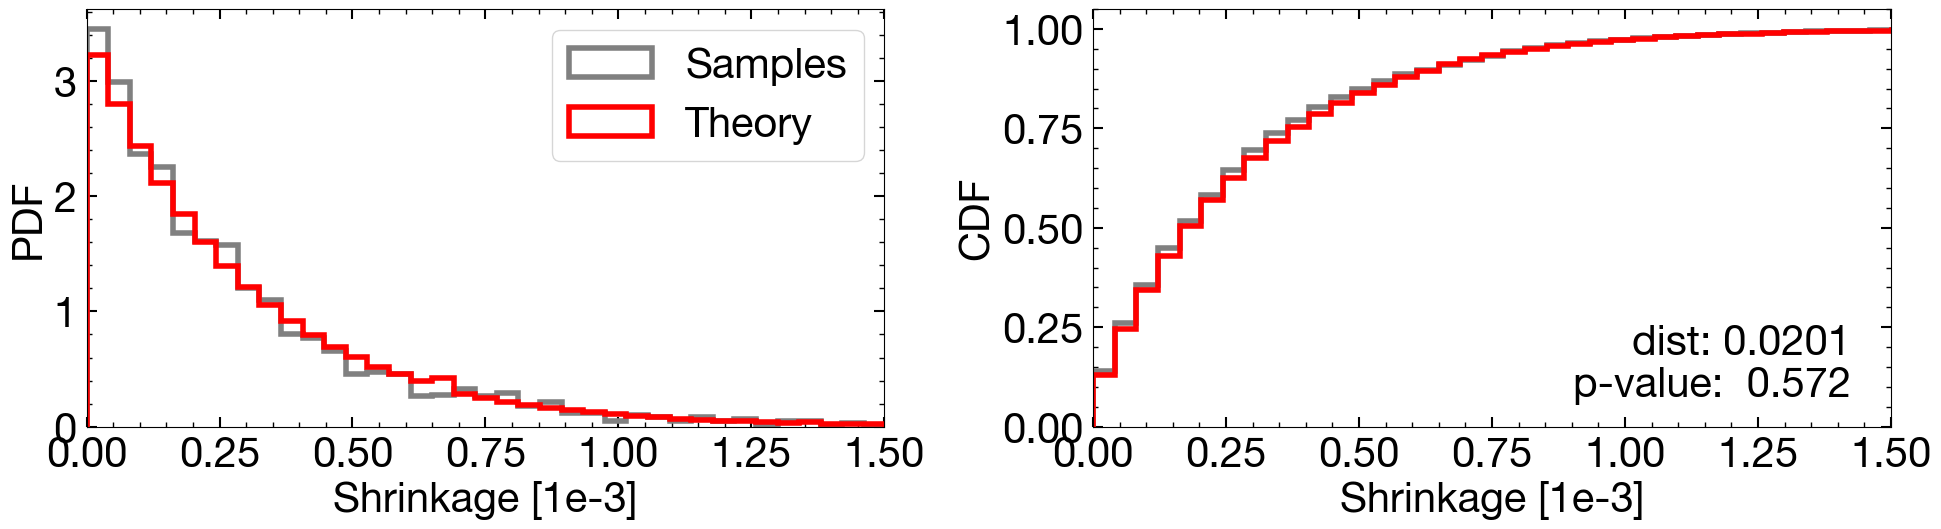

In [14]:
vol = (2 * (-res['logl'])**s)**ndim  # real volumes
t = vol[1:] / vol[:-1]  # shrinkage
S = 1 - t**(1. / ndim)  # slice

# check whether the two distributions are consistent
k_dist, k_pval = kstest(S, cdf)

# PDF
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
ax = axes[0]
pdfgrid = pdf(xgrid)
n, b, p = ax.hist(S * 1e3, bins=50, histtype='step', 
                  color='gray', density=True, lw=4, label='Samples')
ax.hist(xgrid * 1e3, bins=b, color='red', density=True,
        weights=pdfgrid, lw=4, histtype='step', label='Theory')
ax.set_xlabel('Shrinkage [1e-3]')
ax.set_xlim([0., 1.5])
ax.set_ylabel('PDF')
ax.legend()

# CDF
ax = axes[1]
cdfgrid = cdf(xgrid)
n, b, p = ax.hist(S * 1e3, bins=50, histtype='step',
                  cumulative=True, color='gray', 
                  density=True, lw=4, label='Theory')
ax.hist(xgrid * 1e3, bins=b, color='red', density=True,
        weights=pdfgrid, lw=4, cumulative=True,
        histtype='step', label='Theory')
ax.set_xlabel('Shrinkage [1e-3]')
ax.set_xlim([0., 1.5])
ax.set_ylabel('CDF')
ax.text(0.95, 0.2, 'dist: {:6.3}'.format(k_dist), 
        horizontalalignment='right', verticalalignment='center',
        transform=ax.transAxes)
ax.text(0.95, 0.1, 'p-value: {:6.3}'.format(k_pval), 
        horizontalalignment='right', verticalalignment='center',
        transform=ax.transAxes)

plt.tight_layout()